In [1]:
import subprocess
import pandas as pd
import os
from os import path
import tempfile
from IPython.display import clear_output, display
import numpy as np
from ipywidgets import IntProgress

import numpy as np
from jigsaw.crossing.geometry import line_of_points, polysides, is_point_in_poly
from jigsaw.crossing.make_puzzle import (make_puzzle,
                                         canonize,
                                         randomize_rotation, delete_pieces_from_existing_puzzle)
from jigsaw.crossing.serialization import write_pieces, write_rels, read_pieces, read_rels
from jigsaw.crossing.make_puzzle import Puzzle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from os import path, makedirs
from shutil import rmtree
from itertools import product
from os import path
import cv2
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import pandas as pd
import math as math
import shutil

%matplotlib inline
matplotlib.rc('font', size=22)

# Visualization Methods

In [2]:
# Plot a puzzle's pieces (polys) - with no pictorial data.
def plot_puzzle(ax, polys):
    ax.add_collection(PolyCollection(polys,
                                     array=np.random.random(len(polys)) * 500,
                                     cmap='Set3',
                                     linewidths=(0,),
                                     edgecolors='black'))
    ax.autoscale_view()

def plot_puzzle_custom(ax, polys, width=4, color='yellow'):
    ax.add_collection(PolyCollection(polys,
                                     linewidths=(width,),
                                     facecolors=(0, 0, 0, 0),
                                     edgecolors=color))
    ax.autoscale_view()

## Apictorial visualization

In [3]:
def print_apictorial_puzzle(in_dir, out_dir, size=1):
    
    c_puzzle = read_pieces(in_dir)

    figs = [plt.subplots(figsize=(size, size)) for _ in range(1)]

    for (fig, ax), pieces in zip(figs, [c_puzzle]):
        plot_puzzle(ax, pieces)
    ax.axis('off')
        

        
    fig.savefig(out_dir,
                        dpi=1200,
                        bbox_inches = 'tight',
                        pad_inches = 0)
    
    return fig

## Pictorial visualization

In [4]:
# Prints the pieces' position and borders within the puzzle's ground_truth picture
def print_pictorial_puzzle_with_full_pic(pic_path, pieces_path, out_path):
    pic = cv2.cvtColor(cv2.imread(pic_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    height, width = pic.shape[:2]
    pic = cv2.resize(pic, dsize=(width // 10, height // 10), interpolation=cv2.INTER_CUBIC)
    #pic = pic[:250, ...]
    plt.imshow(pic)
    h, w = pic.shape[:2]
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    #shape_to_cut = np.array([
     #   [0, h // 3],
      #  [w//4, 0],
       # [3 * w//4, 0],
        #[w, 2 * h // 3],
        #[5 * w // 6, h],
        #[0, 4 * w // 7]
    #])
    pieces = read_pieces(pieces_path)
    fig, ax = plt.subplots(figsize = [x / 30 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='white')
    mask = np.zeros_like(pic)
    cv2.drawContours(mask,
                     [shape_to_cut.astype(np.int32)],
                     contourIdx=-1,
                     color=(1, 1, 1),
                     thickness=-1,
                     lineType=cv2.LINE_AA)
    ax.imshow(pic * mask)
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight')

In [5]:
# Prints the pieces' position and borders within the puzzle's ground_truth picture and 'crops' everything else
import itertools
def print_pictorial_puzzle(pic_path, pieces_path, out_path):
    pic = cv2.cvtColor(cv2.imread(pic_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    height, width = pic.shape[:2]
    pic = cv2.resize(pic, dsize=(width // 10, height // 10), interpolation=cv2.INTER_CUBIC)
    #pic = pic[:250, ...]
    plt.imshow(pic)
    h, w = pic.shape[:2]

    pieces = read_pieces(pieces_path)
    #shape = sum(pieces, [])
    to_convex = np.array(list(itertools.chain.from_iterable(pieces)))


    
    shape_to_cut = cv2.convexHull(to_convex.astype(np.float32)).squeeze()
    
    fig, ax = plt.subplots(figsize = [x / 30 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='white')
    mask = np.zeros_like(pic)
    cv2.drawContours(mask,
                     [shape_to_cut.astype(np.int32)],
                     contourIdx=-1,
                     color=(1, 1, 1),
                     thickness=-1,
                     lineType=cv2.LINE_AA)
    ax.imshow(pic * mask)
    ax.axis('off')
    fig.savefig(out_path, bbox_inches='tight')

# Noise Generation Methods

In [81]:
# For given Xi and puzzle shape, calculates the puzzles epsilon by finding the puzzle shape's diameter
def calculate_epsilon(shape, Xi):
    if (Xi <= 0):
        return 0
    diameter = calculate_diameter(shape)
    return (Xi/100)*diameter

def calculate_diameter(shape):
    diameter = 0
    for i, p1 in enumerate(shape):
        for p2 in shape[i+1:]:
            length = np.linalg.norm([p2[0]-p1[0], p2[1]-p1[1]])
            if (length > diameter):
                diameter = length
    return diameter

In [82]:
# Given a puzzle and epsilon (and an optional threshold) , returns a new puzzle with noised pieces and fixed relationships 
# while safely cleaning automatically-erased pieces (and also pieces whose diameter is smaller than threshold, if given one)

def apply_noise_on_puzzle(pieces, rels, epsilon, threshold=-1):
    noised_pieces, erased_indices = create_noised_pieces(pieces, epsilon, threshold)
    print(f"amount of erased pieces = {len(erased_indices)}")
    # print(f"noised pieces = {noised_pieces}")
    return delete_pieces_from_existing_puzzle(noised_pieces, rels, erased_indices)

# For given epsilon and pieces, applies noise on the pieces and documents automatically erased pieces (returns them as empty lists).
# Can also check if a noised piece's diameter is smaller than a pre determined threshold, and erase it too.
def create_noised_pieces(pieces, epsilon, threshold=-1):
    noised_pieces = []
    erased_pieces_indexes = []
    if (epsilon <= 0):
        return pieces, erased_pieces_indexes
    for i, piece in enumerate(pieces):
        noised_piece, erased = inner_noise(piece, epsilon)
        if (erased):
            erased_pieces_indexes.append(i)
            noised_pieces.append([])
        elif threshold != -1:
            if is_piece_too_small(noised_piece, threshold):
                erased_pieces_indexes.append(i)
                noised_pieces.append([])
        else:
             noised_pieces.append(noised_piece)
    return np.array(noised_pieces), erased_pieces_indexes

# Calculates a piece's diameter and checks if its smaller than a pre-determined threshold.
def is_piece_too_small(piece, threshold):
    return calculate_diameter(piece) < threshold

In [79]:
from random import uniform
  
# For every vertice in poly:
# 1. Generates a unit vector, directed to a random directionl between its two edges.
# 2. Randomly generates the noise size (to a limit of epsilon), multiplies it by the direction vector
# and adds it to the vertice (thus moving it).
# 3. Checks if the new noised poly intersects with itself, or was dragged out of the original poly's borders 
# (thus, got "erased" due to the noise)
def inner_noise(poly, epsilon):
    noised_poly = []
    erased = False
    original_diameter = calculate_diameter(poly) 
    for i, v in enumerate(poly):
        if (i == 0):
            neighbors = [poly[i+1], poly[-1]]
        elif (i == len(poly)-1):
            neighbors = [poly[0], poly[i-1]]
        else:
            neighbors = [poly[i-1], poly[i+1]]
        random_point = [uniform(neighbors[0][0], neighbors[1][0]), uniform(neighbors[0][1], neighbors[1][1])]
        direction = [random_point[0] - v[0], random_point[1] - v[1]]
        direction_unit = direction / np.linalg.norm(direction)
        noise_size = uniform(0, epsilon)
        if noise_size >= original_diameter:
            erased = True
            break
        noised_v = v + noise_size*direction_unit
        noised_poly.append(noised_v)   
        if ~is_point_in_poly(noised_v, poly):
            erased = True
            break
    if ~erased:
        erased = check_self_intersection(noised_poly)
    return np.array(noised_poly), erased

# Checks if a polygon is self-intersecting, by checking if one pair of its non-neighboring edges intersects
def check_self_intersection(poly):
    edges = polysides(poly)
    for i, edge1 in enumerate(edges):
        for edge2 in edges[i+2:-1]:
            if (check_edges_intersection(edge1, edge2)):
                return True
        if ((i != 0) and (i < len(edges)-2)):
            if (check_edges_intersection(edge1, edges[-1])):
                return True
    return False

# Checks if 2 edges (of type [x1 y1 x2 y2]) intersect by comparing points triplets' orientation and covering general and special cases
def check_edges_intersection(edge1, edge2):
    p1 = [edge1[0], edge1[1]]
    p2 = [edge1[2], edge1[3]]
    p3 = [edge2[0], edge2[1]]
    p4 = [edge2[2], edge2[3]]
    
    orientation1_2_3 = check_orientation(p1, p2, p3)
    if ((orientation1_2_3 == 0) and on_segment(p1, p2, p3)): # Checks special case
        return True
    orientation1_2_4 = check_orientation(p1, p2, p4)
    if ((orientation1_2_4 == 0) and on_segment(p1, p2, p4)): # Checks special case
        return True
    orientation3_4_1 = check_orientation(p3, p4, p1)
    if ((orientation3_4_1 == 0) and on_segment(p3, p4, p1)): # Checks special case
        return True
    orientation3_4_2 = check_orientation(p3, p4, p2)
    if ((orientation3_4_2 == 0) and on_segment(p3, p4, p2)): # Checks special case
        return True
    
    # General cases
    if ((orientation1_2_3 != orientation1_2_4) and (orientation3_4_1 != orientation3_4_2)):
        return True
    
    return False
    
#Checks the orientation between 3 given points (by comparing each pair of points' slope). Returns 1 for clockwise, 0 for colinear, -1 for counter-clockwise
def check_orientation(p1, p2, p3):
    val = (float(p2[1]-p1[1]) * float(p3[0]-p2[0])) - (float(p2[0]-p1[0]) * float(p3[1]-p2[1]))
    if (val > 0):
        return 1
    elif (val < 0):
        return -1
    else:
        return 0

# Given 3 collinear points, checks if p3 is on the line segment [p1,p2] 
def on_segment(p1, p2, p3):
    if ((p3[0] <= max(p2[0],p1[0])) and (p3[0] >= min(p2[0],p1[0])) and (p3[1] <= max(p2[1],p1[1])) and (p3[1] >= min(p2[1],p1[1]))):
        return True
    return False

# Synthesis Methods

In [9]:
from itertools import islice
# Creates a single circle / polygonal / square random  'crossing cuts' puzzle
def random_cc_circle_puzzle(num_lines, w=100):
    circ_range = np.arange(0, 2 * np.pi, np.pi / 16)
    
    shape_to_cut = 0.5 * w * np.c_[np.cos(circ_range), np.sin(circ_range)]
    
    ts = np.random.uniform(0, 2 * np.pi, size=(num_lines, 2))
    
    p0, p1 = [0.5 * w * np.c_[np.cos(col), np.sin(col)]
              for col in [ts[:,0], ts[:, 1]]] 
    lines = line_of_points(p0, p1)
    return make_puzzle(shape_to_cut, lines)

def random_cc_poly_puzzle(num_lines, w=100, return_meta=False):
    L = 0
    while L < 40: 
        to_convex = np.random.uniform(0, w,
                                      size=(np.random.randint(15, 40), 2))

        rect = cv2.minAreaRect(to_convex.astype(np.float32))
        (_, _), (r_w, r_h), _ = rect
        L = min(r_w, r_h)
    
    to_convex *= w / L
    
    shape_to_cut = cv2.convexHull(to_convex.astype(np.float32)).squeeze()
    
    b_rect = cv2.boundingRect(to_convex.astype(np.float32))
    
    new_L = max(b_rect[2:])
    
    rnd_pts = np.array(list(islice(cuts_in_S(new_L, shape_to_cut), num_lines)))
    
    lines = line_of_points(rnd_pts[:, :2], rnd_pts[:, 2:])
    
    puzzle = make_puzzle(shape_to_cut, lines)
    if return_meta:
        return (puzzle, to_convex, shape_to_cut)
    else:
        return puzzle
    
def random_cc_square_puzzle(num_lines, w=100):
    shape_to_cut = np.array([
      [0, 0],
      [w, 0],
      [w, w],
      [0, w]
    ])
    rnd_pts = np.random.uniform(0, w, size=(num_lines, 4))
    lines = line_of_points(rnd_pts[:, :2], rnd_pts[:, 2:])
    return make_puzzle(shape_to_cut, lines)

# A begginer's attempt to simplify the variaty of puzzle shapes.
def random_cc_puzzle(num_lines, shape="square", w=100, return_meta=False):
    if (shape == "circle"):
        return random_cc_circle_puzzle(num_lines, w)
    elif (shape == "polygonal"):
        return random_cc_poly_puzzle(num_lines, w, return_meta)
    else:
        return random_cc_square_puzzle(num_lines, w)    

# Returns square by default
def gen_cc_puzzle_by_shape(shape):
    if (shape == "circle"):
        return random_cc_circle_puzzle
    elif (shape == "polygonal"):
        return random_cc_poly_puzzle
    else:
        return random_cc_square_puzzle
    
def cuts_in_S(w, S):
    while True:
        pts = np.random.uniform(0, w, size=(4))
        pt0 = tuple(pts[:2])
        pt1 = tuple(pts[2:])
        if all([cv2.pointPolygonTest(S, pt, False) == 1.0
                for pt in [pt0, pt1]]):
            yield pt0 + pt1

# Apictorial Puzzles Synthesizer

In [10]:
# Creates a random puzzle of a single noise volume / no noise. 
def create_apictorial_puzzle(base_dir, num_lines, epsilon=0, shape="square"):
    gen_puzzle = gen_cc_puzzle_by_shape(shape)
    puzzle = gen_puzzle(num_lines)
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    shuffled_pieces = [randomize_rotation(canonize(puzzle.pieces))]
    if (epsilon > 0):
        noised_pieces = [inner_noise(p, epsilon) for p in puzzle.pieces] 
        shuffled_pieces = randomize_rotation(canonize(noised_pieces))

        write_pieces(noised_pieces, path.join(base_dir, f"ground_truth_noise_{epsilon}.csv"))
    write_pieces(shuffled_pieces, path.join(base_dir, f"pieces_noise_{epsilon}.csv"))
        
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"Total number of pieces: {len(puzzle.pieces)}\nTotal number of cuts: {num_lines}\nNoise level: {epsilon}%\nShape: {shape}")
    f.close()

In [11]:
# Generates multiple test puzzles of multiple noise volumes.
def create_apictorial_puzzles(base_dir, num_lines, epsilons=[0], shape="square"):
    gen_puzzle = gen_cc_puzzle_by_shape(shape)
    puzzle = gen_puzzle(num_lines)
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    noised_pieces = puzzle.pieces
    noise_index = 0
    noise_index_documentation = []
    for epsilon in epsilons:
        if (epsilon > 0):
            noised_pieces = [inner_noise(p, epsilon) for p in puzzle.pieces] 
        shuffled_pieces = randomize_rotation(canonize(noised_pieces))
        
        write_pieces(noised_pieces, path.join(base_dir, f"ground_truth_noise_{noise_index}.csv"))
        write_pieces(shuffled_pieces, path.join(base_dir, f"pieces_noise_{noise_index}.csv"))
        noise_index_documentation.append(f"noise_{noise_index} = noise level {epsilon}%")
        noise_index = noise_index + 1
        
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"Total number of pieces: {len(puzzle.pieces)}\nTotal number of cuts: {num_lines}\nNoise levels: {noise_index_documentation}\nShape: {shape}")
    f.close()
        

In [12]:
# Synthesizes a random apictorial puzzle with a given number of cuts(num_lines), a given shape(square/polygonal/circle) and a given noise level (epsilon)
def synthesize_apictorial_puzzle(out_dir, num_lines, shape="square", epsilon=0, w=100):
    create_apictorial_puzzle(out_dir, num_lines, epsilon, shape)
    
def synthesize_apictorial_puzzles(out_dir, num_lines, shape="square", epsilons=[0], w=100):
    create_apictorial_puzzles(out_dir, num_lines, epsilons, shape)

In [ ]:
#Activates the synthesizer
base_dir = f"resynthesizer_test/synthisizer_test/mass/"
num_lines = 30
shape = "square"
epsilon = 1
w = 100
#synthesize_apictorial_puzzle(base_dir, num_lines, shape, epsilon, w)
epsilons = [0,1,2,3,4]
synthesize_apictorial_puzzles(base_dir, num_lines, shape, epsilons, w)

in_dir = path.join(base_dir, "ground_truth_puzzle.csv")
out_dir = path.join(base_dir, "ground_truth.png")
print_apictorial_puzzle(in_dir, out_dir, size=0.5)
in_dir = path.join(base_dir, f"ground_truth_noise_1.csv")
out_dir = path.join(base_dir, "noised_pieces.png")
print_apictorial_puzzle(in_dir, out_dir, size=0.5)

# Pictorial Puzzles Synthesizer

In [39]:
from jigsaw.crossing import serialization

def read_pic(in_dir, compressBy=10):
    pic = cv2.cvtColor(cv2.imread(in_dir, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    height, width = pic.shape[:2]
    pic = cv2.resize(pic, dsize=(width // 10, height // 10), interpolation=cv2.INTER_CUBIC)
    return pic

def piece_rotate(img, piece, mask, theta):
    rows, cols = img.shape[:2]
    t1 = np.float32([
        [1, 0, -cols / 2],
        [0, 1, -rows / 2],
        [0, 0, 1]
    ])
    
    rot = np.float32([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    
    t2 = np.float32([
        [1, 0, cols / 2],
        [0, 1, rows / 2],
        [0, 0, 1]
    ])
    
    M = (t2 @ rot @ t1)
    
    
    
    piece_h = np.c_[piece, np.ones(piece.shape[0])]
    piece_rot = piece_h @ M.T
    piece_rot = piece_rot[:, :2] / piece_rot[:, 2][:, None]
    
    x, y, w, h = cv2.boundingRect(piece_rot.astype(np.float32))
    
    t3 = np.float32([
        [1, 0, -x],
        [0, 1, -y],
        [0, 0, 1]
    ])
    
    M = t3 @ M
    piece_rot = piece_h @ M.T
    piece_rot = piece_rot[:, :2] / piece_rot[:, 2][:, None]
    
    img_rot = cv2.warpAffine(img,
                          M[:2],
                          (w, h),
                          flags=cv2.INTER_NEAREST)
    
    mask_rot = cv2.warpAffine(mask,
                              M[:2],
                              (w, h),
                              flags=cv2.INTER_NEAREST)
    
    
    return (img_rot, piece_rot, mask_rot)   

def create_pieces_images(pic, pieces, rotate=True):
    pieces_32f = [p.astype(np.float32) for p in pieces]

    pieces_images_orig = []
    piece_masks_orig = []
    pieces_normed_orig = []

    pieces_images = []
    piece_masks = []
    pieces_normed = []

    for i, piece in enumerate(pieces_32f):
        x, y, w, h = cv2.boundingRect(piece)
        p_norm = piece - np.array([x, y])
        croped = pic[y:y + h, x:x + w].copy().astype(np.uint8)

        mask = np.zeros(croped.shape[:2], np.uint8)

        cv2.drawContours(mask,
                         [p_norm.astype(np.int32)],
                         contourIdx=-1,
                         color=(255, 255, 255),
                         thickness=-1,
                         lineType=cv2.LINE_AA)

        dst = cv2.bitwise_and(croped, croped, mask=mask)

        pieces_images_orig.append(dst)
        piece_masks_orig.append(mask)
        pieces_normed_orig.append(p_norm)

        img_rot, piece_rot, mask_rot = piece_rotate(dst, p_norm, mask, np.random.uniform(0, 2 * np.pi))
        pieces_images.append(img_rot)
        piece_masks.append(mask_rot)
        pieces_normed.append(piece_rot)
    if (rotate==True):
        return (pieces_normed, pieces_images)
    else:
        return (pieces_normed_orig, pieces_images_orig)

def write_pieces_images(pieces_images, out_dir):
    for i, img in enumerate(pieces_images):
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path.join(out_dir, f"{i}.png"), img_bgr)


In [14]:
def create_strictly_square_puzzle(pic_dir, base_dir, rotate=False, square_size=25, Xi=0, threshold=-1):
    pic = read_pic(pic_dir)
    height, width = pic.shape[:2]
    pic = cv2.resize(pic, dsize=(round(width/square_size)*square_size, round(height/square_size)*square_size), interpolation=cv2.INTER_CUBIC)
    h, w = pic.shape[:2]
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(0, a, square_size)
                    for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]),
                              np.array([x, h]))
               for x in x_range]

    y_lines = [line_of_points(np.array([0, y]),
                              np.array([w, y]))
               for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    if (Xi > 0):
        epsilon = calculate_epsilon(shape_to_cut, Xi)
        puzzle = apply_noise_on_puzzle(puzzle.pieces, puzzle.relationships, epsilon, threshold)
    
    pieces = puzzle.pieces
    
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')

    pieces, pieces_images = create_pieces_images(pic, pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))
    
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"total number of pieces: {len(puzzle.pieces)}\nnoise level: {noise}\nrotated: {rotate}")
    f.close()
    
    return fig

In [15]:
def create_perturbed_square_puzzle(pic_dir, base_dir, num_lines, noise=0, perturbation_rate=0.15, copy_pic=False, rotate=True):
    pic = cv2.cvtColor(cv2.imread(pic_dir, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    h, w = pic.shape[:2]
    pic = cv2.resize(pic, dsize=((w//(num_lines+2))*(num_lines+2), (h//(num_lines+2))*(num_lines+2)), interpolation=cv2.INTER_CUBIC)
    h, w = pic.shape[:2]

    square_size = (h+w)/(num_lines+2)
    perturbation = perturbation_rate*square_size
    
    num_vertical_lines = round(h*num_lines/(w+h))
    
    h = round((num_vertical_lines+1)*square_size)
    w = round((num_lines-num_vertical_lines+1)*square_size)
    
    pic = cv2.resize(pic, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
        
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    

    x_range, y_range = [np.arange(square_size, a, square_size) for a in [w, h]]
    
    perturbations_x, perturbations_y = [np.random.uniform(low=-perturbation, high=perturbation, size=(len(r), 4)) for r in [x_range, y_range]]
    perturbations_x[[0, -1], :] = 0
    perturbations_y[:, [0, -1]] = 0

    x_lines = [line_of_points(np.array([x, 0]) + per[:2], np.array([x, h]) + per[2:]) for x, per in zip(x_range, perturbations_x)]

    y_lines = [line_of_points(np.array([0, y]) + per[:2], np.array([w, y]) + per[2:]) for y, per in zip(y_range, perturbations_y)]

    lines = np.vstack(x_lines + y_lines)
    
    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    if (noise > 0):
        write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle_without_noise.csv"))
        pieces = [inner_noise(p, noise) for p in puzzle.pieces]
    else:
        pieces = puzzle.pieces
    
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))

    
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=5, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')

    pieces, pieces_images = create_pieces_images(pic, pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))
    
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"Total number of cuts: {len(lines)}\nTotal number of pieces: {len(puzzle.pieces)}\nNoise level: {noise}%\nPerturbation rate = {100*perturbation_rate}%")
    f.close()
    
    if (copy_pic):
        shutil.copy(pic_dir, path.join(base_dir, "original_image.jpg"))
        #cv2.imwrite(path.join(pic_dir, "original_image.png"), (pic, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    return fig
    

In [16]:
# Tests the perturbed square puzzle synthesizer
#base_dir = f"resynthesizer_test/synthisizer_test/perturbed/"
#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
pic_dir = f"images/db3/image (540).jpg"
base_dir = "New_DBs/DB3/lines_90/noise_level_5/p9/"


fig = create_perturbed_square_puzzle(pic_dir, base_dir, num_lines=40, noise=5, perturbation_rate=0.30, copy_pic=True, rotate=True)

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [17]:
import csv

def create_polygonal_puzzle(pic_dir, base_dir, num_lines, noise=0, copy_pic=False, rotate=True, delete_small_pieces=False, min_piece_size=2):
    pic = cv2.cvtColor(cv2.imread(pic_dir, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    h, w = pic.shape[:2]
    min_size = min(h,w)
    
    L = 0
    while L < min_size/2: 
        to_convex = np.random.uniform(0, min_size,
                                      size=(np.random.randint(15, 40), 2))

        rect = cv2.minAreaRect(to_convex.astype(np.float32))
        (_, _), (r_w, r_h), _ = rect
        L = min(r_w, r_h)
    
    to_convex *= min_size / L
    
    shape_to_cut = cv2.convexHull(to_convex.astype(np.float32)).squeeze()
    
    b_rect = cv2.boundingRect(to_convex.astype(np.float32))
    
    new_L = max(b_rect[2:])
    
    rnd_pts = np.array(list(islice(cuts_in_S(new_L, shape_to_cut), num_lines)))
    
    lines = line_of_points(rnd_pts[:, :2], rnd_pts[:, 2:])
    
    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels_including_failed_pieces.csv"))
    
    if (noise > 0):
        write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle_without_noise.csv"))
        pieces = [inner_noise(p, noise) for p in puzzle.pieces]
    else:
        pieces = puzzle.pieces
        
    write_pieces(pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    
    pieces_to_convex = np.array(list(itertools.chain.from_iterable(pieces)))
    global_puzzle_shape = cv2.convexHull(pieces_to_convex.astype(np.float32)).squeeze()
    
    fig, ax = plt.subplots(figsize = [x / 30 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='white')
    mask = np.zeros_like(pic)
    cv2.drawContours(mask,
                     [global_puzzle_shape.astype(np.int32)],
                     contourIdx=-1,
                     color=(1, 1, 1),
                     thickness=-1,
                     lineType=cv2.LINE_AA)
    ax.imshow(pic * mask)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')
    
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))        
    
    pieces_32f = [p.astype(np.float32) for p in pieces]

    pieces = []
    failed_pieces_documentation = []
    failed_pieces = []

    for i, p in enumerate(pieces_32f):
        x, y, w, h = cv2.boundingRect(p)
        piece = p - np.array([x, y])
        cropped = pic[y:y + h, x:x + w].copy().astype(np.uint8)

        mask = np.zeros(cropped.shape[:2], np.uint8)

        cv2.drawContours(mask,
                         [piece.astype(np.int32)],
                         contourIdx=-1,
                         color=(255, 255, 255),
                         thickness=-1,
                         lineType=cv2.LINE_AA)

        piece_img = cv2.bitwise_and(cropped, cropped, mask=mask)
        
        if (piece_img is None):
            failed_pieces_documentation.append(f"Piece {i} with original coordinates {piece}")
            failed_pieces.append(i)
        else:
            if (rotate):
                piece_img, piece, mask_rot = piece_rotate(piece_img, piece, mask, np.random.uniform(0, 2 * np.pi))
            h, w = piece_img.shape[:2]
            if (delete_small_pieces and min(h,w) < min_piece_size):
                failed_pieces_documentation.append(f"Piece {i} with original coordinates {piece}")
                failed_pieces.append(i)
            else:
                pieces.append(piece)
                img_bgr = cv2.cvtColor(piece_img, cv2.COLOR_RGB2BGR)
                cv2.imwrite(path.join(base_dir, f"{i}.png"), img_bgr)

    
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))         
                
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"Total number of cuts: {len(lines)}\nTotal number of pieces: {len(puzzle.pieces)}\nTotal amount of automatically erased pieces = {len(failed_pieces)}\nNoise level: {noise}%")
    f.close()
        
            
    
    if (len(failed_pieces) > 0):
        f = open(path.join(base_dir, "failed_pieces.txt"), "w+")
        failures_report = '\n'.join(failed_pieces_documentation)
        f.write(failures_report)
        f.close()
    
    if (copy_pic):
        shutil.copy(pic_dir, path.join(base_dir, "original_image.jpg"))
        #cv2.imwrite(path.join(pic_dir, "original_image.png"), (pic, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    
    with open(path.join(base_dir, "ground_truth_rels_including_failed_pieces.csv"), "rt") as inp, open(path.join(base_dir, "ground_truth_rels.csv"), 'wt') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            include_row = True
            for i in failed_pieces:
                if (row[0]==f"{i}" or row[2]==f"{i}"):
                    include_row = False
            if include_row:
                s = ""
                for word in row:
                    s = s + f"{word},"
                s = s[:len(s)-1] + '\n'
                out.write(s)
    
    return fig

In [18]:
# Tests the polygonal synthesizer PERCENTAGES
base_dir = f"temp/1/"
pic_dir = f"temp/1/image.jpg"

fig = create_polygonal_puzzle(pic_dir, base_dir, num_lines=5, noise=5, copy_pic=False, rotate=True, delete_small_pieces=True, min_piece_size=2)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Tests the polygonal synthesizer
base_dir = f"temp/3/"
pic_dir = f"temp/3/image.jpg"

fig = create_polygonal_puzzle(pic_dir, base_dir, num_lines=2, noise=0, copy_pic=False, rotate=True, delete_small_pieces=True, min_piece_size=2)

In [ ]:
# Tests the polygonal synthesizer
base_dir = f"temp/2/"
pic_dir = f"temp/2/image.jpg"

fig = create_polygonal_puzzle(pic_dir, base_dir, num_lines=5, noise=5, copy_pic=False, rotate=True, delete_small_pieces=True, min_piece_size=2)

In [63]:
def create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, noise=0, square_size=25, rotate=False, copy_pic=False, minimize_pic=True, threshold=-1, document_pieces_without_noise=False):
    pic = cv2.cvtColor(cv2.imread(pic_dir, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    height, width = pic.shape[:2]
    min_size = min(height, width)
    if (height == min_size):
        pic = pic[0:min_size, (width - min_size)//2:((width - min_size)//2 + min_size)]
    else:
        pic = pic[(height - min_size)//2:((height - min_size)//2 + min_size), 0:min_size]
    height, width = pic.shape[:2]
    desired_size = round(square_size*(math.sqrt(num_of_pieces)))
    if (desired_size > min_size):
        raise Exception("The image's size is not compatible with the desired number of pieces and desired piece's size")
    if (minimize_pic):
        pic = cv2.resize(pic, dsize=(desired_size, desired_size), interpolation=cv2.INTER_CUBIC)
    else:
        if (num_of_pieces >= 100):
            while (min_size > 6*desired_size):
                pic = cv2.resize(pic, dsize=(round(0.9*min_size), round(0.9*min_size)), interpolation=cv2.INTER_CUBIC)
                min_size,height = pic.shape[:2]
        else:
            while (min_size > 6*desired_size):
                pic = cv2.resize(pic, dsize=(round(0.9*min_size), round(0.9*min_size)), interpolation=cv2.INTER_CUBIC)
                min_size,height = pic.shape[:2]
            #pic = pic[((min_size//10)-desired_size)//2:((min_size//10)+desired_size)//2, ((min_size//10)-desired_size)//2:((min_size//10)+desired_size)//2]
        #pic = pic[(min_size-desired_size)//2:(min_size+desired_size)//2, (min_size-desired_size)//2:(min_size+desired_size)//2]
        #pic = cv2.resize(pic, dsize=(desired_size, desired_size), interpolation=cv2.INTER_CUBIC)
    #pic = cv2.resize(pic, dsize=(desired_size, desired_size), interpolation=cv2.INTER_CUBIC)
    height, width = pic.shape[:2]
    pic = pic[(height - desired_size)//2:((height - desired_size)//2 + desired_size), (width - desired_size)//2:((width - desired_size)//2 + desired_size)]
    h, w = pic.shape[:2]
    #print(f"w={w} h={h} minsize = {min_size} desiredsize = {desired_size}")
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(0, a, square_size) for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]), np.array([x, h])) for x in x_range]

    y_lines = [line_of_points(np.array([0, y]), np.array([w, y])) for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    if (noise > 0):
        if (document_pieces_without_noise):
            write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle_without_noise.csv"))
            write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels_without_noise.csv"))
        epsilon = calculate_epsilon(shape_to_cut, noise)
        puzzle = apply_noise_on_puzzle(puzzle.pieces, puzzle.relationships, epsilon, threshold)
    
    pieces = puzzle.pieces
    
    write_pieces(pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')
    pieces, pieces_images = create_pieces_images(pic, pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))
    
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"Total number of cuts: {len(lines)}\nTotal number of pieces: {len(puzzle.pieces)}\nPiece size: {square_size}x{square_size} pixels\nNoise level: {noise}%\nRotated: {rotate}")
    f.close()
    
    if (copy_pic):
        shutil.copy(pic_dir, path.join(base_dir, "original_image.jpg"))
        #cv2.imwrite(path.join(pic_dir, "original_image.png"), (pic, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    return fig

<ipython-input-82-6c7006a6a780>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(noised_pieces), erased_pieces_indexes


amount of erased pieces = 37


AttributeError: 'NoneType' object has no attribute 'shape'

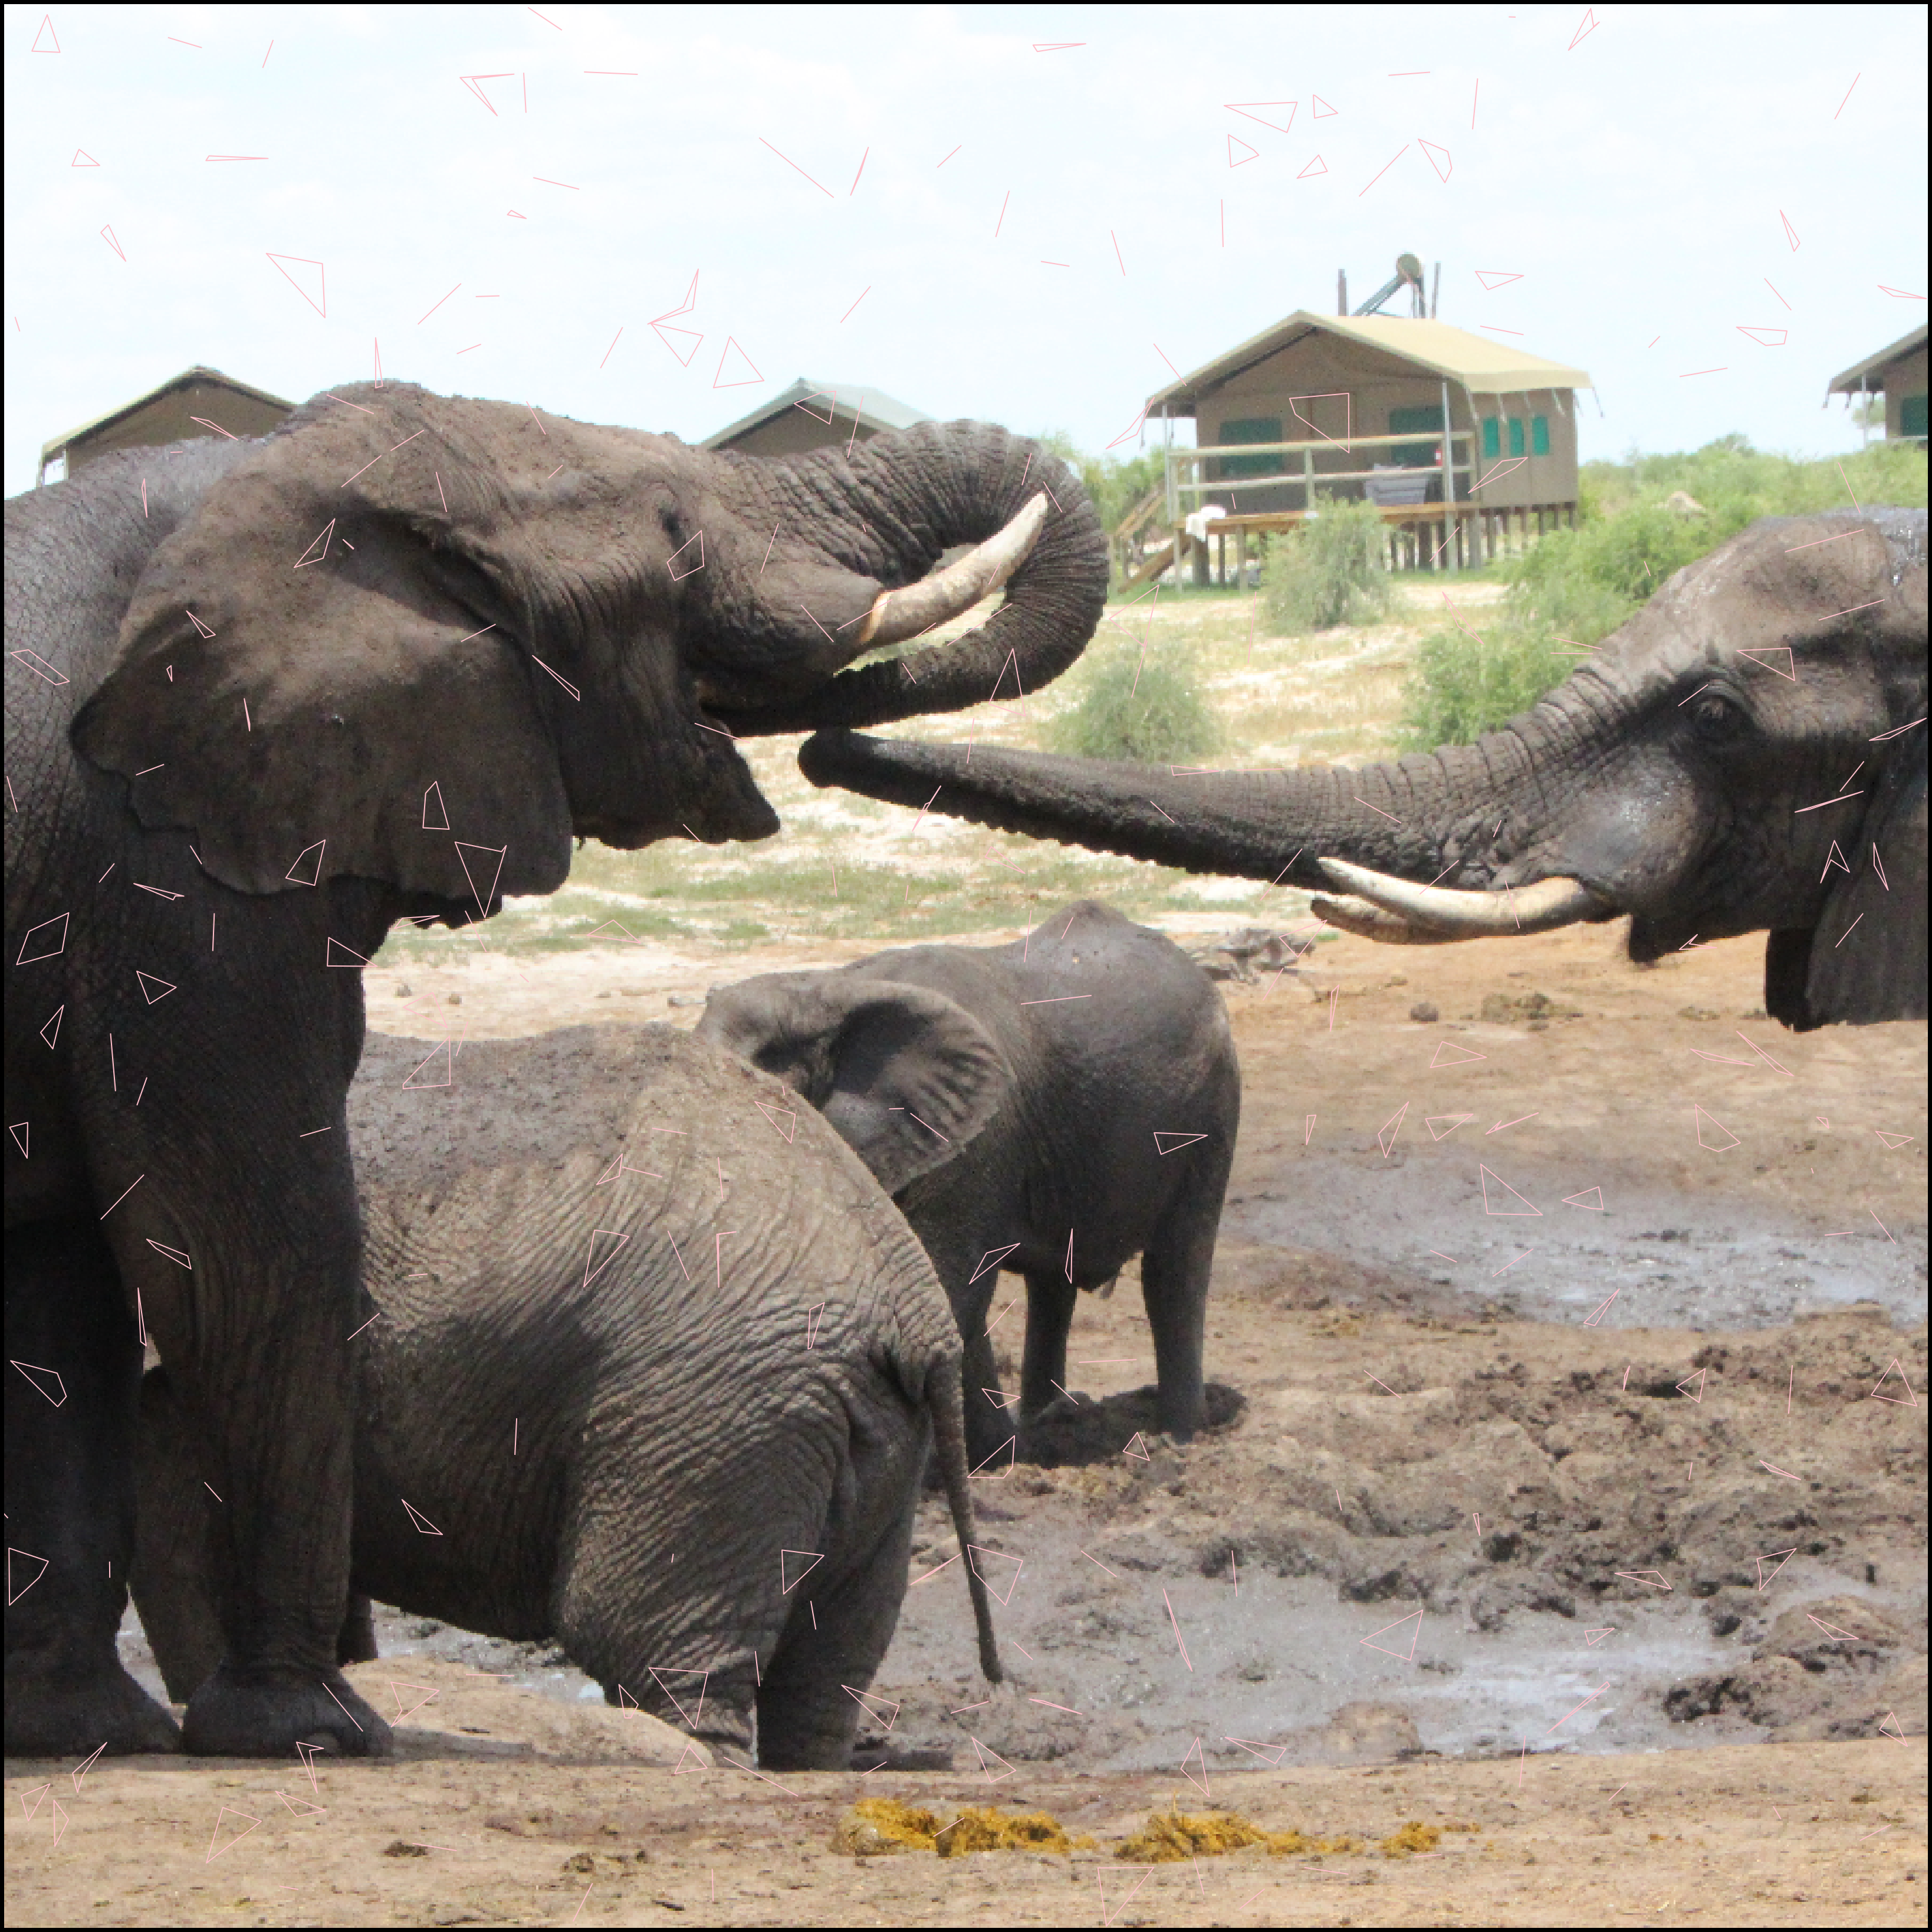

In [89]:
# Tests the strictly square puzzle synthesizer
base_dir = f"resynthesizer_test/synthisizer_test/pictorial/"
pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic.JPG"
#pic_dir = f"Unsplash images datasets/New folder/New folder/bulksplash-katietreadway-EwE4tBYh3ms.jpg"
#pic_dir = f"Unsplash images datasets/New folder/New folder/bulksplash-charlesdeluvio-8Z39ewlr2Ww.jpg"
#pic_dir = f"Unsplash images datasets/New folder/bulksplash-artshamss-C2rMUl3CLtc.jpg"
#pic_dir = f"Unsplash images datasets/New folder/New folder/thomas-le-pRJhn4MbsMM-unsplash.jpg"

#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(50*50), rotate=True, noise=2, square_size=10, copy_pic=True, minimize_pic=False)
fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(30*30), noise=5, square_size=30, rotate=True, copy_pic=True, minimize_pic=True, threshold=-1, document_pieces_without_noise=True)

#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


# Printer

In [ ]:
# Prints an apictorial puzzle
i1 = list(np.arange(5,20,1))
i2 = list(np.arange(20,51,5))
n_cuts_i = i1 + i2
puzzles_i = list(np.arange(0,10,1))
#print(n_cuts_i)
#print(puzzles_i)

p_i = 6
n_i = 20

in_dir = f"resynthesizer_test/synthisizer_test/ground_truth_puzzle.csv"
out_dir = f"resynthesizer_test/synthisizer_test/ground_truth.png"
#in_dir = f"resynthesizer_test/p46/ground_truth_pieces.csv"
#in_dir = f"DB1/cuts_{n_i}/p{p_i}/ground_truth_puzzle.csv" 
#out_dir = f"DB1/cuts_{n_i}/p{p_i}/p{n_i}ground_truth.pdf"

#in_dir = f"resynthesizer_test/pieces.csv"
#out_dir = f"resynthesizer_test/ground_truth.pdf"

print_apictorial_puzzle(in_dir, out_dir)

#for n_i in n_cuts_i:
 #   for p_i in puzzles_i:
        

In [ ]:
# Prints a pictorial puzzle
pic_path = "resynthesizer_test/p38/ground_truth_pic.png"
pieces_path = "resynthesizer_test/p38/ground_truth_pieces.csv"
out_path = "resynthesizer_test/ground_truth.png"

print_pictorial_puzzle1(pic_path,pieces_path,out_path)

# Piece Matcher

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_piece(pic_dir, poly):
    img = cv2.imread("0.png")

    poly = np.array([
    [0.0,30.066232612696894,-9.286562808178616],
    [0.0,0.6049794607897354,40.50447018833367],
    [0.0,-33.3148142461977,22.633303670207482],
    [0.0,2.64360217271107,-53.85121105036254],
    ])

    tl = np.min(poly[:, 1:], axis=0)

    h, w = img.shape[:2]
    plt.imshow(img)

    plt.fill(
            poly[:, 1] - tl[0],
            poly[:, 2] - tl[1],
            alpha=0.5,
            color='orange')
    plt.show()
    return plt

[-91.42161208 -77.00183226]
[ 22.52736409 172.78835355 170.37073068   0.        ] [  3.83495798   0.         152.43078515 151.74158591]


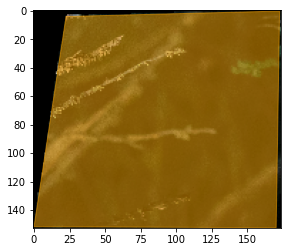

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("resynthesizer_test/p4/0.png")

poly = np.array([
[0.0, -68.89424799132335, -73.16687428186303],
[0.0, 81.36674146670579, -77.00183226228266],
[0.0, 78.94911860396373, 75.4289528923937],
[0.0, -91.42161207934619, 74.739753651752],
])

tl = np.min(poly[:, 1:], axis=0)
print(tl)
h, w = img.shape[:2]
plt.imshow(img)
print(
poly[:, 1] - tl[0],
poly[:, 2] - tl[1]
)
plt.fill(
        poly[:, 1] - tl[0],
        poly[:, 2] - tl[1],
        alpha=0.5,
        color='orange')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("resynthesizer_test/p18/19.png")

poly = np.array([
[19.0, -47.111087540780545, 19.983586939596393],
[19.0, -59.405179821266984, 3.753050327247223],
[19.0, 2.256516714038753, -60.58659374180937],
[19.0, 54.19995240625826, -82.37304933003102],
[19.0, 25.383083648407364, 37.0802109209088],
[19.0, 21.22290325263816, 40.01273663885772],
[19.0, 3.4538113407049877, 42.13005824523029],
])

tl = np.min(poly[:, 1:], axis=0)
print(tl)
h, w = img.shape[:2]
plt.imshow(img)
print(
poly[:, 1] - tl[0],
poly[:, 2] - tl[1]
)
plt.fill(
        poly[:, 1] - tl[0],
        poly[:, 2] - tl[1],
        alpha=0.5,
        color='orange')
plt.show()

# Mass Synthesizer

In [19]:
# Generates DB1
base_dir = f"New_DBs/DB1/"
shape = "circle"
w = 100
epsilons = [0,0.1,0.5,1,2,5]
variations = range(30)
range_of_lines = range(10, 101, 10)
for num_lines in range_of_lines:
    lines_dir = path.join(base_dir, f"lines_{num_lines}")
    if not os.path.exists(lines_dir):
        os.makedirs(lines_dir)
    for puzzle_index in variations:
        curr_dir = path.join(lines_dir, f"p{puzzle_index}")
        if not os.path.exists(curr_dir):
            os.makedirs(curr_dir)
        synthesize_apictorial_puzzles(curr_dir, num_lines, shape, epsilons, w)
        in_dir = path.join(curr_dir, "ground_truth_puzzle.csv")
        out_dir = path.join(curr_dir, "ground_truth.png")
        fig = print_apictorial_puzzle(in_dir, out_dir, size=0.5)
        fig.clf()
        plt.close()
        for i in range(len(epsilons)):
            in_dir = path.join(curr_dir, f"ground_truth_noise_{i}.csv")
            out_dir = path.join(curr_dir, f"ground_truth_noise_{i}.png")
            fig = print_apictorial_puzzle(in_dir, out_dir, size=0.5)
            fig.clf()
            plt.close()

In [20]:
# Generates DB2
base_dir = f"New_DBs/DB2/"
shape = "polygonal"
w = 100
epsilons = [0,0.1,0.5,1,2,5]
variations = range(10)
range_of_lines = range(5, 51, 5)
for num_lines in range_of_lines:
    lines_dir = path.join(base_dir, f"lines_{num_lines}")
    if not os.path.exists(lines_dir):
        os.makedirs(lines_dir)
    for puzzle_index in variations:
        curr_dir = path.join(lines_dir, f"p{puzzle_index}")
        if not os.path.exists(curr_dir):
            os.makedirs(curr_dir)
        synthesize_apictorial_puzzles(curr_dir, num_lines, shape, epsilons, w)
        in_dir = path.join(curr_dir, "ground_truth_puzzle.csv")
        out_dir = path.join(curr_dir, "ground_truth.png")
        fig = print_apictorial_puzzle(in_dir, out_dir, size=0.5)
        fig.clf()
        plt.close()
        for i in range(len(epsilons)):
            in_dir = path.join(curr_dir, f"ground_truth_noise_{i}.csv")
            out_dir = path.join(curr_dir, f"ground_truth_noise_{i}.png")
            fig = print_apictorial_puzzle(in_dir, out_dir, size=0.5)
            fig.clf()
            plt.close()

In [ ]:
# Generates DB5
base_dir = f"New_DBs/DB5/"
pics_dir = f"images/"

range_of_lines = range(10, 101, 10)
variations = range(2)
pic_counter = 1
noise_levels = [0,0.1,0.5,1,2,5]
square_sizes = [5,10,15,20,25,30]
for num_lines in range_of_lines:
    lines_dir = path.join(base_dir, f"lines_{num_lines}")
    if not os.path.exists(lines_dir):
        os.makedirs(lines_dir)
    for sq_size in square_sizes:
            square_dir = path.join(lines_dir, f"pieces_size_{sq_size}x{sq_size}")
            if not os.path.exists(square_dir):
                os.makedirs(square_dir)
            for noise_level in noise_levels:
                noise_dir = path.join(square_dir, f"noise_level_{noise_level}")
                if not os.path.exists(noise_dir):
                        os.makedirs(noise_dir)
                for puzzle_index in variations:
                    curr_dir = path.join(noise_dir, f"p{puzzle_index}")
                    if not os.path.exists(curr_dir):
                        os.makedirs(curr_dir)
                    pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
                    pic_counter = pic_counter + 1
                    if (sq_size <= 10):
                        fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, curr_dir, num_of_pieces=(num_lines*num_lines), rotate=True, noise=noise_level, square_size=sq_size, copy_pic=True, minimize_pic=False)
                    else:
                        fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, curr_dir, num_of_pieces=(num_lines*num_lines), rotate=True, noise=noise_level, square_size=sq_size, copy_pic=True, minimize_pic=True)
                    fig.clf()
                    plt.close()

#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(45*45), rotate=True, noise=2, square_size=30, copy_pic=False, minimize_pic=True)
#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


In [21]:
# Generates DB5, while images will be sorted by size (ie width and height)

base_dir = f"New_DBs/DB5/"
pics_dir = f"images/db5/"

range_of_lines = range(5, 51, 5)
variations = range(10)
pic_counter = 1
noise_levels = [0,0.1,0.5,1,2,5]
square_sizes = [5,10,15,20,25,30]
failures = []
for sq_size in square_sizes:
    for num_lines in range_of_lines:
        for noise_level in noise_levels:
            for puzzle_index in variations:
                curr_dir = path.join(base_dir, f"lines_{2*num_lines}/pieces_size_{sq_size}x{sq_size}/noise_level_{noise_level}/p{puzzle_index}") #num_lines is multiplied by 2 as there are num_lines horizontal cuts and num_lines vertical cuts.
                if not os.path.exists(curr_dir):
                    os.makedirs(curr_dir)
                if (num_lines == 5 or (sq_size <= 10 and num_lines < 15)):
                    pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
                    pic_counter = pic_counter + 1
                    fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, curr_dir, num_of_pieces=(num_lines*num_lines), noise=noise_level, square_size=sq_size, rotate=True, copy_pic=True, minimize_pic=False)
                else:
                    while True:
                        pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
                        pic_counter = pic_counter + 1
                        try:
                            fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, curr_dir, num_of_pieces=(num_lines*num_lines), noise=noise_level, square_size=sq_size, rotate=True, copy_pic=True, minimize_pic=True)
                        except Exception:
                            failures.append(f"Failed to generate lines_{num_lines},pieces_size_{sq_size}x{sq_size},noise_level_{noise_level},p{puzzle_index},with image {pic_counter-1}\n")
                            continue
                        break   
                fig.clf()
                plt.close()
print(failures)
f = open(path.join(base_dir, "Synthesis_documentation.txt"), "w+")
f.write(f"Puzzles synthesized = {len(noise_levels)*len(square_sizes)*len(range_of_lines)*len(variations)}\nLast image used = image {pic_counter}\nFailures = \n{failures}")
f.close()



#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(45*45), rotate=True, noise=2, square_size=30, copy_pic=False, minimize_pic=True)
#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


[]


In [19]:
# Generates DB3, while images will be sorted by size (ie width and height)
base_dir = f"New_DBs/DB3/"
pics_dir = f"images/db3/"

range_of_lines = range(100, 101, 10)
variations = range(10)
pic_counter = 541
first_pic = pic_counter
noise_levels = [0,0.1,0.5,1,2,5]
square_sizes = [5,10,15,20,25,30]
failures = []
for num_lines in range_of_lines:
    for noise_level in noise_levels:
        for puzzle_index in variations:
            curr_dir = path.join(base_dir, f"lines_{num_lines}/noise_level_{noise_level}/p{puzzle_index}")
            if not os.path.exists(curr_dir):
                os.makedirs(curr_dir)
            pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
            pic_counter = pic_counter + 1
            try:
                fig = create_perturbed_square_puzzle(pic_dir, curr_dir, num_lines, noise_level, perturbation_rate=0.15, copy_pic=True, rotate=True) 
            except MemoryError:
                print(f"Stopped due to memory error. stopped in {curr_dir} at pic {pic_dir}")
                break
            fig.clf()
            plt.close()
f = open(path.join(base_dir, "Synthesis_documentation.txt"), "w+")
f.write(f"Puzzles synthesized = {len(noise_levels)*len(range_of_lines)*len(variations)}\nFirst image used = {first_pic}\nLast image used = image {pic_counter}\nFailures = \n{failures}")
f.close()

#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(45*45), rotate=True, noise=2, square_size=30, copy_pic=False, minimize_pic=True)
#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


In [18]:
# Generates DB4, while images will be sorted by size (ie width and height)
base_dir = f"New_DBs/DB4/"
pics_dir = f"images/db4/"

range_of_lines = range(10, 101, 10)
variations = range(10)
pic_counter = 1
first_pic = pic_counter
puzzle_counter = 0
noise_levels = [0,0.1,0.5,1,2,5]
square_sizes = [5,10,15,20,25,30]
failures = []
for num_lines in range_of_lines:
    for noise_level in noise_levels:
        for puzzle_index in variations:
            curr_dir = path.join(base_dir, f"lines_{num_lines}/noise_level_{noise_level}/p{puzzle_index}")
            if not os.path.exists(curr_dir):
                os.makedirs(curr_dir)
            pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
            pic_counter = pic_counter + 1
            try:
                fig = create_polygonal_puzzle(pic_dir, curr_dir, num_lines, noise_level, copy_pic=True, rotate=True, delete_small_pieces=True, min_piece_size=2)
                fig.clf()
                plt.close()
            except MemoryError:
                print(f"Stopped due to memory error. stopped in {curr_dir} at pic {pic_dir}")
                break
            puzzle_counter = puzzle_counter + 1
f = open(path.join(base_dir, "Synthesis_documentation.txt"), "w+")
f.write(f"Puzzles synthesized = {puzzle_counter}\nFirst image used = {first_pic}\nLast image used = image {pic_counter}\nFailures = \n{failures}")
f.close()

#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(45*45), rotate=True, noise=2, square_size=30, copy_pic=False, minimize_pic=True)
#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


In [ ]:
# Generates DB4, while images will be sorted by size (ie width and height)
base_dir = f"New_DBs/DB4/"
pics_dir = f"images/db4/"

range_of_lines = range(60, 101, 10)
variations = range(10)
pic_counter = 1
first_pic = pic_counter
puzzle_counter = 0
noise_levels = [0,0.1,0.5,1,2,5]
square_sizes = [5,10,15,20,25,30]
failures = []
for num_lines in range_of_lines:
    for noise_level in noise_levels:
        for puzzle_index in variations:
            curr_dir = path.join(base_dir, f"lines_{num_lines}/noise_level_{noise_level}/p{puzzle_index}")
            if not os.path.exists(curr_dir):
                os.makedirs(curr_dir)
            pic_dir = path.join(pics_dir, f"image ({pic_counter}).jpg")
            pic_counter = pic_counter + 1
            try:
                fig = create_polygonal_puzzle(pic_dir, curr_dir, num_lines, noise_level, copy_pic=True, rotate=True, delete_small_pieces=True, min_piece_size=2)
                fig.clf()
                plt.close()
            except MemoryError:
                print(f"Stopped due to memory error. stopped in {curr_dir} at pic {pic_dir}")
                break
            puzzle_counter = puzzle_counter + 1
f = open(path.join(base_dir, "Synthesis_documentation.txt"), "w+")
f.write(f"Puzzles synthesized = {puzzle_counter}\nFirst image used = {first_pic}\nLast image used = image {pic_counter}\nFailures = \n{failures}")
f.close()

#pic_dir = f"resynthesizer_test/synthisizer_test/pictorial/pic/pic.jpg"
#create_strictly_square_puzzle(pic_dir, base_dir, rotate=True, square_size=25, noise=3)
#create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, num_of_pieces=100, rotate=True, noise=3, copy_pic=True)
#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=(45*45), rotate=True, noise=2, square_size=30, copy_pic=False, minimize_pic=True)
#fig2 = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=2, square_size=25, copy_pic=False, minimize_pic=True)

#fig = create_strictly_square_puzzle_by_num_of_pieces_with_square_size(pic_dir, base_dir, num_of_pieces=2500, rotate=True, noise=3, square_size=30, copy_pic=False)


# Pieces Bag Maker

In [143]:
display_multiple_images(pieces_images)

NameError: name 'pieces_images' is not defined

In [146]:
def display_multiple_images(images):
    combined = cv2.vconcat([images])
    plt.imshow(combined)


    

def plot_pic_sol(pieces_sol, transformations, piece_images, pieces_normed):
    X, Y, W, H = cv2.boundingRect(np.vstack(pieces_sol).astype(np.float32))
    
    M_global = np.eye(3)
    M_global[:2, 2] = [-X, -Y]
    canvas = np.zeros((H, W, 3), np.uint8)
    
    for row, img, piece in zip(transformations, piece_images, pieces_normed):
        R = row[:4].reshape(2, 2)
        t = row[-2:]
        
        center_mass = np.mean(piece, axis=0)
        
        M_center = np.eye(3)
        M_center[:2, 2] = -center_mass
        
        
        M_rot = np.eye(3)
        M_rot[:2, :2] = R
        
        M_t = np.eye(3)
        M_t[:2, 2] = t
        
        
        M =  M_global @ M_t @  M_rot @ M_center
        
        
        next_canvas = cv2.warpAffine(
            src=img,
            M=M[:2],
            dsize=(W, H))
        canvas |= next_canvas
    
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.axis('off')
    return canvas

## Trash bin

In [ ]:
def plot_puzzle(ax, polys, width=4, color='yellow'):
    np.random.seed(0)
    ax.add_collection(PolyCollection(polys,
                                     linewidths=(width,),
                                     facecolors=(0, 0, 0, 0),
                                     edgecolors=color))
    ax.autoscale_view()

In [ ]:
#older code
# Creates a random puzzle of a single noise volume / no noise. 
def create_test_puzzle(base_dir, num_lines, epsilon=0, gen_puzzle=gen_cc_puzzle_by_shape):
    puzzle = gen_puzzle(num_lines)
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    shuffled_pieces = [randomize_rotation(canonize(puzzle.pieces))]
    if (epsilon > 0):
        noised_pieces = [inner_noise(p, epsilon) for p in puzzle.pieces] 
        shuffled_pieces = [randomize_rotation(canonize(x))
                           for x in noised_pieces]
        for i, p in enumerate(noised_pieces):
            write_pieces(p, path.join(base_dir, f"err{i}_n.csv"))
        
    for i, p in enumerate(shuffled_pieces):
        write_pieces(p, path.join(base_dir, f"err{i}_s.csv"))
        
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"total number of pieces: {len(puzzle.pieces)}\nnoise level: {epsilon}\nshape: {shape}")
    f.close()

In [ ]:
def create_strictly_square_puzzle1(pic_dir, base_dir, rotate=False, square_size=25):
    np.random.seed(0)
    pic = read_pic(pic_dir)
    height, width = pic.shape[:2]
    pic = cv2.resize(pic, dsize=(width-(width%square_size), height-(height%square_size)), interpolation=cv2.INTER_CUBIC)
    h, w = pic.shape[:2]
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(0, a, square_size)
                    for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]),
                              np.array([x, h]))
               for x in x_range]

    y_lines = [line_of_points(np.array([0, y]),
                              np.array([w, y]))
               for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, puzzle.pieces, width=2, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    pieces, pieces_images = create_pieces_images(pic, puzzle.pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))

In [ ]:
def create_square_puzzle(pic_dir, base_dir, rotate=False, square_size=85):
    np.random.seed(0)
    pic = read_pic(pic_dir)
    h, w = pic.shape[:2]
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(-100, a, square_size)
                    for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]),
                              np.array([x, h]))
               for x in x_range]

    y_lines = [line_of_points(np.array([0, y]),
                              np.array([w, y]))
               for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, puzzle.pieces, width=2, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    pieces, pieces_images = create_pieces_images(pic, puzzle.pieces)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))

In [ ]:
# Generates multiple test puzzles of multiple noise volumes.
def create_apictorial_puzzles1(base_dir, num_lines, epsilons=[0], gen_puzzle=gen_cc_puzzle_by_shape):
    puzzle = gen_puzzle(num_lines)
    
    try:
        noised_pieces = [[inner_noise(p, epsilon) for p in puzzle.pieces]
                         for epsilon in epsilons]
    except TypeError:
        noised_pieces = [[inner_noise(p, epsilons) for p in puzzle.pieces]]
    
    shuffled_pieces = [randomize_rotation(canonize(x))
                       for x in noised_pieces]
    
    print(f"num parts: {len(puzzle.pieces)}")
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    for i, p in enumerate(shuffled_pieces):
        write_pieces(p, path.join(base_dir, f"err{i}_s.csv"))
        
    for i, p in enumerate(noised_pieces):
        write_pieces(p, path.join(base_dir, f"err{i}_n.csv"))
        

In [ ]:
import math as math
import shutil

def create_strictly_square_puzzle_by_num_of_pieces_with_square_size11(pic_dir, base_dir, rotate=False, num_of_pieces=2500, noise=0, square_size=25, copy_pic=False, minimize_pic=True):
    np.random.seed(0)
    pic = cv2.cvtColor(cv2.imread(pic_dir, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    height, width = pic.shape[:2]
    min_size = min(height, width)
    if (height == min_size):
        pic = pic[0:min_size, (width - min_size)//2:((width - min_size)//2 + min_size)]
    else:
        pic = pic[(height - min_size)//2:((height - min_size)//2 + min_size), 0:min_size]
    height, width = pic.shape[:2]
    desired_size = round(square_size*(math.sqrt(num_of_pieces)))
    if (desired_size > min_size):
        raise Exception("The image's size is not compatible with the desired number of pieces and desired piece's size")
    if (minimize_pic):
        pic = cv2.resize(pic, dsize=(desired_size, desired_size))
    else:
        while (min_size > 6*desired_size):
            pic = cv2.resize(pic, dsize=(min_size//2, min_size//2))
            min_size,width = pic.shape[:2]
            #pic = pic[((min_size//10)-desired_size)//2:((min_size//10)+desired_size)//2, ((min_size//10)-desired_size)//2:((min_size//10)+desired_size)//2]
        #pic = pic[(min_size-desired_size)//2:(min_size+desired_size)//2, (min_size-desired_size)//2:(min_size+desired_size)//2]
        #pic = cv2.resize(pic, dsize=(desired_size, desired_size), interpolation=cv2.INTER_CUBIC)
    #height, width = pic.shape[:2]
    img = pic[0:desired_size, 0:desired_size]
    h, w = img.shape[:2]
    print(f"w={w} h={h} minsize = {min_size} desiredsize = {desired_size}")
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(0, a, square_size) for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]), np.array([x, h])) for x in x_range]

    y_lines = [line_of_points(np.array([0, y]), np.array([w, y])) for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    if (noise > 0):
        pieces = [inner_noise(p, noise) for p in puzzle.pieces]
    else:
        pieces = puzzle.pieces
    
    fig, ax = plt.subplots(figsize = [x / 15 for x in img.shape[:2]], facecolor='black')
    print(f"w={w} h={h} minsize = {min_size} desiredsize = {desired_size} x_lines = {len(x_lines)} y_lines = {len(y_lines)} lines = {len(lines)} lines_no_dup = {len(np.unique(lines, axis=0))} ax = {ax} pieces = {len(pieces)}")
    plot_puzzle_custom(ax, pieces, width=2, color='pink')
    ax.imshow(img[0:desired_size, 0:desired_size])
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')

    pieces, pieces_images = create_pieces_images(img, pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))
    
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"total number of pieces: {len(puzzle.pieces)}\npiece size: {square_size}x{square_size} pixels\nnoise level: {noise}%\nrotated: {rotate}")
    f.close()
    
    if (copy_pic):
        shutil.copy(pic_dir, base_dir)
        cv2.imwrite(path.join(pic_dir, "original_image.png"), (img, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    return fig

In [ ]:
def get_pertubed_crossing_lines(h, w, num_lines):
    num_vertical_lines = round(h*num_lines/(w+h))
    num_horizontal_lines = num_lines - num_vertical_lines
    rnd_x_points = np.random.uniform(0, w, size=(num_horizontal_lines))
    x_lines = line_of_points(np.array([[x, 0] for x in rnd_x_points]), np.array([[x, h] for x in rnd_x_points]))
    rnd_y_points = np.random.uniform(0, h, size=(num_vertical_lines))
    y_lines = line_of_points(np.array([[0, y] for y in rnd_y_points]), np.array([[w, y] for y in rnd_y_points]))
    return np.vstack(x_lines + y_lines)

In [181]:
def poly_vecs(poly):
    p_sides = polysides(poly)
    return np.roll(p_sides[:, 2:] - p_sides[:, :2], 1, axis=0)

# Adds noise (of volume epsilon) to a given piece. returns the noisy piece.
def inner_noise(poly, epsilon):
    vec_sides = polysides(poly_vecs(poly))
    v1 = vec_sides[:, :2]
    v2 = vec_sides[:, 2:]
    
    v1_len, v2_len = [np.linalg.norm(v, axis=1)
                      for v in [v1, v2]]
    
    v1n, v2n = [v / v_len.reshape(len(v), -1)
                for v, v_len in [(v1, v1_len), (v2, v2_len)]]
    
    noise_coeff = np.minimum(0.5 * np.random.uniform(0, epsilon, size=(len(v1), 2)),
                             0.1 * np.c_[v1_len, v2_len])
    
    v1_off, v2_off = [v * noise_coeff[:, i].reshape(len(v), -1)
                      for i, v in enumerate([v1n, v2n])]
    
    return poly - v1_off + v2_off

def cuts_in_S(w, S):
    while True:
        pts = np.random.uniform(0, w, size=(4))
        pt0 = tuple(pts[:2])
        pt1 = tuple(pts[2:])
        if all([cv2.pointPolygonTest(S, pt, False) == 1.0
                for pt in [pt0, pt1]]):
            yield pt0 + pt1

In [ ]:
def inner_noise(poly, epsilon):
    vec_sides = polysides(poly_vecs(poly))
    v1 = vec_sides[:, :2]
    v2 = vec_sides[:, 2:]
    
    v1_len, v2_len = [np.linalg.norm(v, axis=1)
                      for v in [v1, v2]]
    
    v1n, v2n = [v / v_len.reshape(len(v), -1)
                for v, v_len in [(v1, v1_len), (v2, v2_len)]]
    
    noise_coeff = np.minimum(0.5 * np.random.uniform(0, epsilon, size=(len(v1), 2)),
                             0.1 * np.c_[v1_len, v2_len])
    
    v1_off, v2_off = [v * noise_coeff[:, i].reshape(len(v), -1)
                      for i, v in enumerate([v1n, v2n])]
    
    return poly - v1_off + v2_off


In [227]:
import math as math
import shutil

def create_strictly_square_puzzle_by_num_of_pieces(pic_dir, base_dir, rotate=False, num_of_pieces=2500, noise=0, copy_pic=False, threshold=-1):
    if (num_of_pieces > 2000):
        pic = read_pic(pic_dir, compressBy=5)
    else:
        pic = read_pic(pic_dir, compressBy=5)
    height, width = pic.shape[:2]
    min_size = min(height, width)
    if (height == min_size):
        pic = pic[0:min_size, (width - min_size)//2:((width - min_size)//2 + min_size)]
    else:
        pic = pic[(height - min_size)//2:((height - min_size)//2 + min_size), 0:min_size]
    square_size = min_size / math.sqrt(num_of_pieces)
    pic = cv2.resize(pic, dsize=(min_size, min_size), interpolation=cv2.INTER_CUBIC)
    h, w = pic.shape[:2]
    shape_to_cut = np.array([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])
    x_range, y_range = [np.arange(0, a, square_size) for a in [w, h]]

    x_lines = [line_of_points(np.array([x, 0]), np.array([x, h])) for x in x_range]

    y_lines = [line_of_points(np.array([0, y]), np.array([w, y]))
                   for y in y_range]

    lines = np.vstack(x_lines + y_lines)

    puzzle = make_puzzle(shape_to_cut, lines)
    
    write_pieces(puzzle.pieces, path.join(base_dir, "ground_truth_puzzle.csv"))
    write_rels(puzzle.relationships, path.join(base_dir, "ground_truth_rels.csv"))
    
    if (noise > 0):
        epsilon = calculate_epsilon(shape_to_cut, noise)
        puzzle = apply_noise_on_puzzle(puzzle.pieces, puzzle.relationships, epsilon, threshold)

    pieces = puzzle.pieces
    
    fig, ax = plt.subplots(figsize = [x / 15 for x in pic.shape[:2]], facecolor='black')
    plot_puzzle_custom(ax, pieces, width=2, color='pink')
    ax.imshow(pic)
    ax.axis('off')
    fig.savefig(path.join(base_dir,'ground_truth.jpg'), bbox_inches='tight')

    pieces, pieces_images = create_pieces_images(pic, pieces, rotate)
    write_pieces_images(pieces_images, base_dir)
    canonized_pieces = canonize(pieces)
    write_pieces(canonized_pieces, path.join(base_dir, "pieces.csv"))
    
    f = open(path.join(base_dir, "puzzle_details.txt"), "w+")
    f.write(f"total number of pieces: {len(puzzle.pieces)}\nnoise level(Xi): {noise}\nrotated: {rotate}")
    f.close()
    
    if (copy_pic):
        shutil.copy(pic_dir, base_dir)
        #cv2.imwrite(path.join(pic_dir, "original_image.jpg"), pic)
    
    return fig

In [ ]:
#check check5

In [ ]:
#check check 7